<a href="https://colab.research.google.com/github/carson-edmonds/AAI-511_Final_Project/blob/main/AAI511_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References for Midi loading and conversion: https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c

In [1]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # makes the randomness deterministic

%matplotlib inline
# todo: try %matplotlib widget
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.grid'] = True

In [3]:
!pip install mido
import mido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 849.1 kB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

mid = mido.MidiFile('/content/drive/MyDrive/AAI 511/Final Project/Composer_Dataset/NN_midi_files_extended/train/bach/bach342.mid', clip=True)
mid.tracks

In [ ]:
for m in mid.tracks[1][:20]:
    print(m)

In [10]:
import string
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

In [11]:
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

In [12]:
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [13]:
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

In [14]:
mid_array = mid2arry(mid)

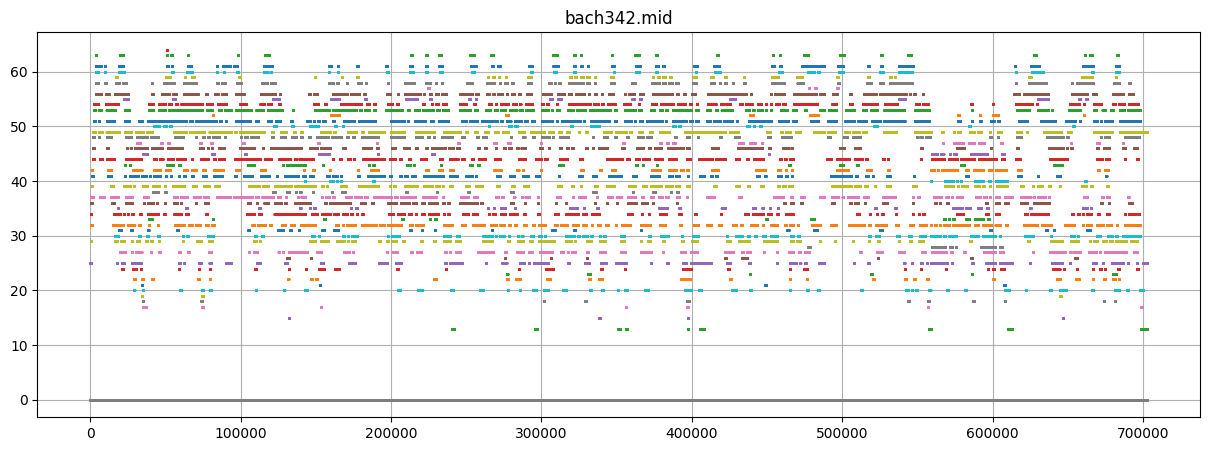

In [16]:
plt.plot(range(mid_array.shape[0]), np.multiply(np.where(mid_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("bach342.mid")
plt.show()